## Homework 4 - Jakub Kuśmierski

### Initialization of the environment

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#The tensorflow library
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf)

import quadratic_equation as qef
importlib.reload(qef);

### Data preparation

In [2]:
x = qef.quadraticEqGenerator(10000)
y = qef.quadraticEqSolution(x)

#Selecting equation only with solution
mask = y[:, 0] != None
x = x[mask].astype(float)
y = y[mask].astype(float)

#Splitting data into training and testing
split_mask = 0.8*len(x)
x_train = x[:int(split_mask),:]
y_train = y[:int(split_mask),:]
x_val = x[int(split_mask):,:]
y_val = y[int(split_mask):,:]

print(colored("Training data shapes: ", "blue"), x_train.shape, y_train.shape)
print(colored("Validation data shapes: ", "blue"), x_val.shape, y_val.shape)

Training data shapes:  (5031, 3) (5031, 2)
Validation data shapes:  (1258, 3) (1258, 2)


/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules/quadratic_equation.py:23: RuntimeWarning: invalid value encountered in sqrt
  result = np.where(delta>0, np.sqrt(delta), 0.0)


### Plotting Function

In [8]:
def plotSolution(x_train, y_train, y_pred):
    
    delta = (y_pred - y_train)/y_train
    delta = delta.flatten()
    threshold = 0.01
    
    print(colored("Fraction of events with Y==Y_pred: ", 'blue'), np.mean(np.isclose(y_train, y_pred)))
    print(colored('Fraction of examples with abs(pull)<0.01: ', 'blue'), np.mean(np.abs(delta) < threshold))
    print(colored('Pull standard deviation: ', 'blue'), delta.std())
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].hist(delta, bins=np.linspace(-1.5,1.5,40))
    ax[0].set_title('(Pred - True)/True')
    
    
    
    
    ax[1].axis(False)
    axis = fig.add_subplot(133, projection='3d')
    delta = (y_pred - y_train)/y_train
    colors = np.abs(delta)<threshold
    colors = np.sum(colors, axis=1)
    cmapName = plt.rcParams["image.cmap"]
    cmap = mpl.colormaps[cmapName]
    
    axis.scatter(x_train[:,0], x_train[:,1], x_train[:,2], c=colors)
    axis.scatter((-2), (-2), (-2), label='none correct', marker='o', color=cmap.colors[1])
    axis.scatter((-2), (-2), (-2), label='single correct', marker='o', color=cmap.colors[128])
    axis.scatter((-2), (-2), (-2), label='double correct', marker='o', color=cmap.colors[-1])
    axis.legend(bbox_to_anchor=(1.5,1), loc='upper left')
    axis.set_xlabel("a")
    axis.set_ylabel("b")
    axis.set_zlabel("c");
    axis.set_xlim([-1.1,1.1])
    axis.set_ylim([-1.1,1.1])
    axis.set_zlim([-1.1,1.1])
    
    
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.35, hspace=0.0)

### Model definition

In [4]:
def getModel(inputShape, nNeurons, lr, hiddenActivation='relu', outputActivation='linear', outputNeurons=1, metrics=['MeanAbsolutePercentageError','RootMeanSquaredError'], kernel_regularizer=None):
    inputs = tf.keras.Input(shape=(inputShape,), name="features")
    x = inputs
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer='he_normal',
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=kernel_regularizer,
                                  name="layer_"+str(iLayer))(x)
        #x = tf.keras.layers.Dropout(name="dropout_layer_"+str(iLayer), rate = 0.2)(x)
            
    outputs = tf.keras.layers.Dense(outputNeurons, activation=outputActivation, name = "output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mape',
                  metrics=metrics)
    return model

### Model initialization and training

I tried many options from changing the number of epochs, to the number of neurons, to changing the number of layers. On top of that, I tested various loss functions like mse, mae, etc. In addition, I changed activation functions - I tested ReLU, sigmoid and tanh. The results shown are the best I have obtained.

In [5]:
InputShape = 3
nNeurons = np.full((8),256)
#nNeurons = [256, 128, 64, 32, 16]
nOutputNeurons = 2
batchSize = 128
nEpochs = 2000
initial_learning_rate = 0.001
nStepsPerEpoch = len(x_train)/batchSize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=20*nStepsPerEpoch,
                    decay_rate=0.95,
                    staircase=True)
karnel_regularization = tf.keras.regularizers.L2(l2 = 0.001)
metics = ['Accuracy', 'FalsePositives']
model = getModel(InputShape, nNeurons, lr_schedule, metrics=None, outputNeurons=nOutputNeurons, kernel_regularizer=karnel_regularization, hiddenActivation='relu')
model.summary()

2025-04-09 19:14:19.190813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-09 19:14:19.190839: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-09 19:14:19.190843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-09 19:14:19.190857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-09 19:14:19.190868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_0 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,082 (1.76 MB)

 Trainable params: 462,082 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000


2025-04-09 19:14:19.735038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-09 19:14:19.739391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 478.8923 - val_loss: 424.7032
Epoch 2/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 774.1987 - val_loss: 181.4272
Epoch 3/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 337.0776 - val_loss: 503.0328
Epoch 4/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 406.1948 - val_loss: 448.0376
Epoch 5/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 271.1396 - val_loss: 610.4984
Epoch 6/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 476.2859 - val_loss: 326.4201
Epoch 7/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 409.0882 - val_loss: 373.9595
Epoch 8/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 491.2066 - val_loss: 425.3434
Epoch 9/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 733.2579 - val_loss: 139.9942
Epoch 10/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 223.3856 - val_loss: 551.4399
Epoch 11/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 192.8574 - val_loss: 320.6250
Epoch 12/2

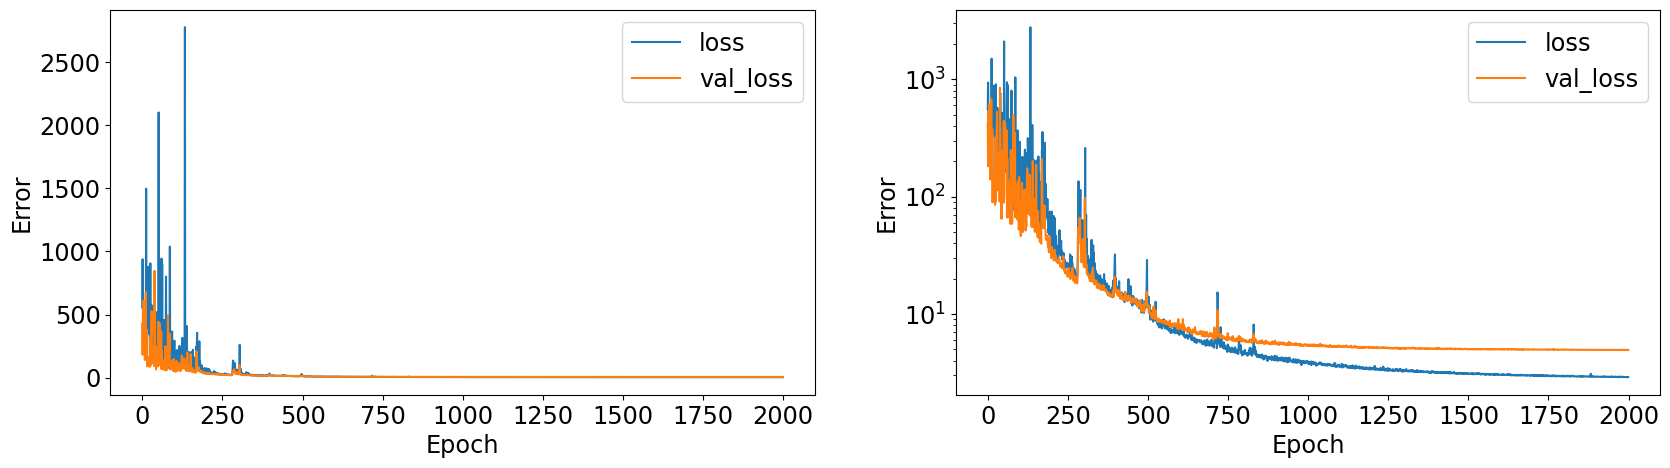

In [6]:
history = model.fit(x=x_train, y=y_train, epochs=nEpochs, batch_size=batchSize, validation_data=(x_val, y_val), verbose=1)
plf.plotTrainHistory(history)

Training dataset.
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fraction of events with Y==Y_pred:  0.0028821307891075333
Fraction of examples with abs(pull)<0.01:  0.9100576426157821
Pull standard deviation:  0.06469447711482701
Validation dataset.
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fraction of events with Y==Y_pred:  0.000794912559618442
Fraction of examples with abs(pull)<0.01:  0.6494435612082671
Pull standard deviation:  0.1293130183624859


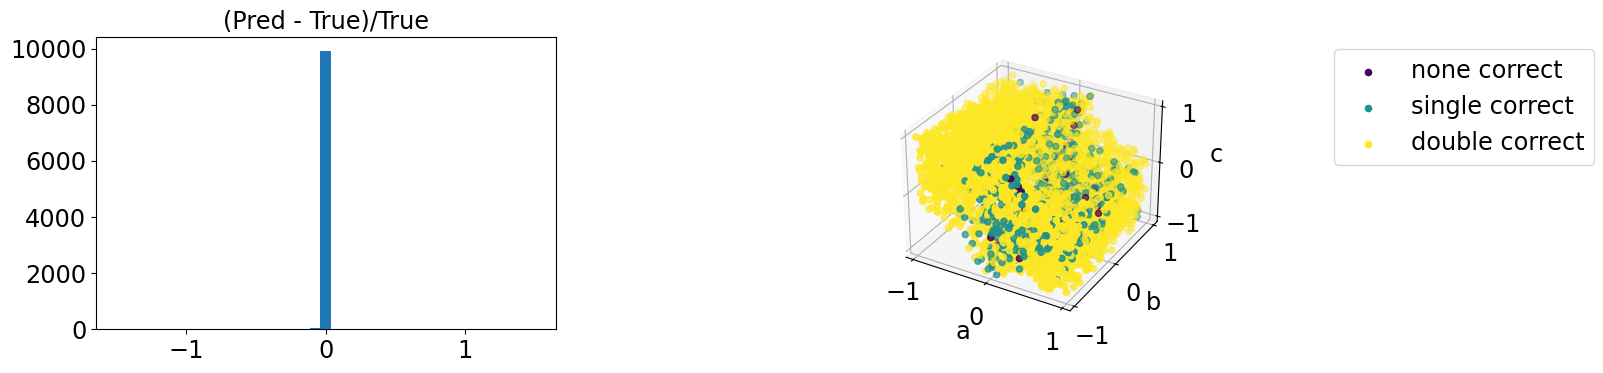

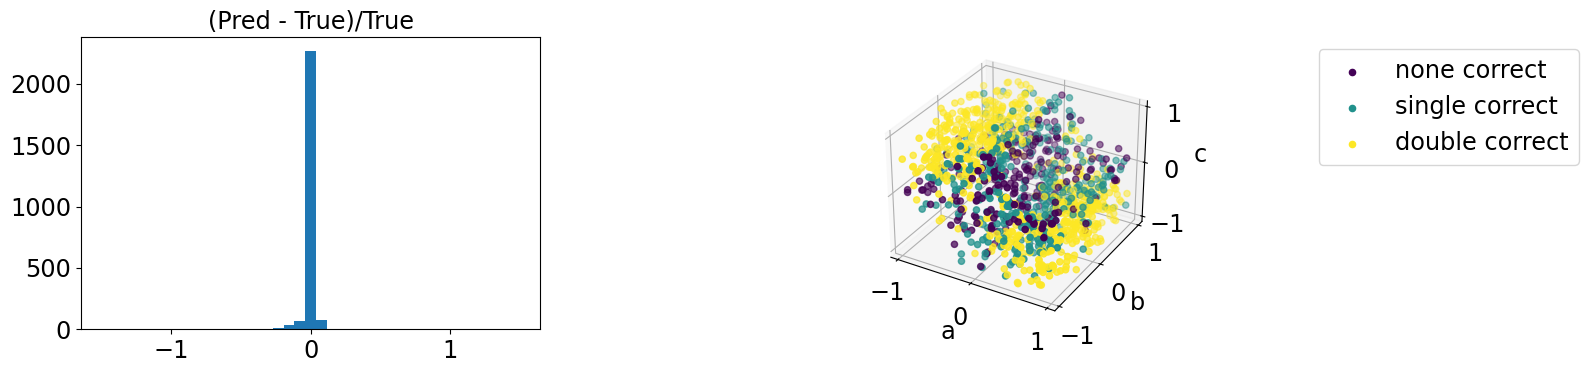

In [9]:
print(colored("Training dataset.","blue"))
y_pred = model.predict(x_train)
plotSolution(x_train, y_train, y_pred)

print(colored("Validation dataset.","blue"))
y_pred = model.predict(x_val)
plotSolution(x_val, y_val, y_pred)